In [70]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mapper_functions import plot_global_tight_pcm, plot_tb_tight_pcm


In [71]:
expt_name = 'LS_DAv8_M36'

start_date = datetime(2002, 10, 1)
end_date = datetime(2006, 10, 1)

start_date_str = start_date.strftime('%Y/%m/%d')
end_date_str = end_date.strftime('%Y/%m/%d')

# Define the path directory
root_directory = f'/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/{expt_name}/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'

In [72]:
# List all tavg24 files in the root directory
files = glob.glob(os.path.join(root_directory, '*tavg24_1d_lnd_Nt*.nc'))

# Filter files based on the date range
filtered_files = []
for file in files:
    # Extract the date part from the filename
    filename = os.path.basename(file)
    date_str = filename.split('.')[-2]  # Extract the date part (e.g., 200401)
    file_date = datetime.strptime(date_str, '%Y%m')

    # Check if the file date is within the range
    if start_date <= file_date < end_date:
        filtered_files.append(file)

# Load the data 
ds = xr.open_mfdataset(filtered_files, combine='nested', concat_dim="time")

# Sort the dataset by the time dimension
ds = ds.sortby('time')

In [73]:
# List all incr files in the root directory
files = glob.glob(os.path.join(root_directory, 'snow_incrs_*.nc4'))

# Filter files based on the date range
filtered_files = []
for file in files:
    # Extract the date part from the filename
    filename = os.path.basename(file)
    date_str = filename.split('_')[-1].split('.')[0]  # Extract the date part (e.g., 200509)
    file_date = datetime.strptime(date_str, '%Y%m')

    # Check if the file date is within the range
    if start_date <= file_date < end_date:
        filtered_files.append(file)

# Load the data 
ds_incr = xr.open_mfdataset(filtered_files, combine='nested', concat_dim="time")

# Sort the dataset by the time dimension
ds_incr = ds_incr.sortby('time')

In [74]:
snow_incr_count = ds_incr['snow_incr_count'].values
snow_incr_mean = ds_incr['snow_incr_mean'].values

# Calculate the total increment
total_increment = snow_incr_count * snow_incr_mean

In [75]:
# Variables in the dataset
variables = {
'sm_surface': 'SFMC',
'sm_rootzone': 'RZMC',
'sm_profile': 'PRMC',
'precipitation_total_surface_flux': 'PRECTOTCORRLAND',
'vegetation_greenness_fraction': 'GRN',
'leaf_area_index': 'LAI',
'snow_mass': 'SNOMASLAND',
'surface_temperature_of_land_incl_snow': 'TSURFLAND',
'soil_temperature_layer_1': 'TSOIL1',
'snowfall_land': 'PRECSNOCORRLAND',
'snow_depth_within_snow_covered_area_fraction_on_land': 'SNODPLAND',
'snowpack_evaporation_latent_heat_flux_on_land': 'LHLANDSBLN',
'overland_runoff_including_throughflow': 'RUNSURFLAND',
'baseflow_flux_land': 'BASEFLOWLAND',
'snowmelt_flux_land': 'SMLAND',
'total_evaporation_land': 'EVLAND',
'net_shortwave_flux_land': 'SWLAND',
'total_water_storage_land': 'TWLAND',
'fractional_area_of_snow_on_land': 'FRLANDSNO'  # New variable added
}

# Open the dataset for a specific file that contains lat/lon for M36 grid
ds_latlon = xr.open_dataset('DAv7_M36.inst3_1d_lndfcstana_Nt.20150901.nc4')

# Extract longitude and latitude variables
lon = ds_latlon['lon']
lat = ds_latlon['lat']

# Determine the number of tiles based on the latitude array
n_tile = len(lat)

# Initialize an observation array with NaN values
# The array has dimensions [n_tile, 3], where:
# - Column 0 is reserved for future use
# - Column 1 stores longitude values
# - Column 2 stores latitude values
map_array = np.empty([n_tile, 3])
map_array.fill(np.nan)
map_array[:, 1] = lon
map_array[:, 2] = lat

In [76]:
# Extract the time array
time_array = ds['time'].values  # This is a numpy datetime64 array

# Convert numpy datetime64 to Python datetime
time_array = time_array.astype('datetime64[M]').astype(object)

# Calculate the number of seconds in each month
seconds_in_month = []
for t in time_array:
    # Start of the current month
    start_of_month = datetime(t.year, t.month, 1)
    # Start of the next month
    if t.month == 12:
        start_of_next_month = datetime(t.year + 1, 1, 1)
    else:
        start_of_next_month = datetime(t.year, t.month + 1, 1)
    # Calculate the number of seconds in the month
    seconds = (start_of_next_month - start_of_month).total_seconds()
    seconds_in_month.append(seconds)

seconds_in_month = np.array(seconds_in_month)
# Reshape seconds_in_month to match the time dimension of var_data
seconds_in_month = seconds_in_month[:, np.newaxis]  # Shape becomes (12, 1)

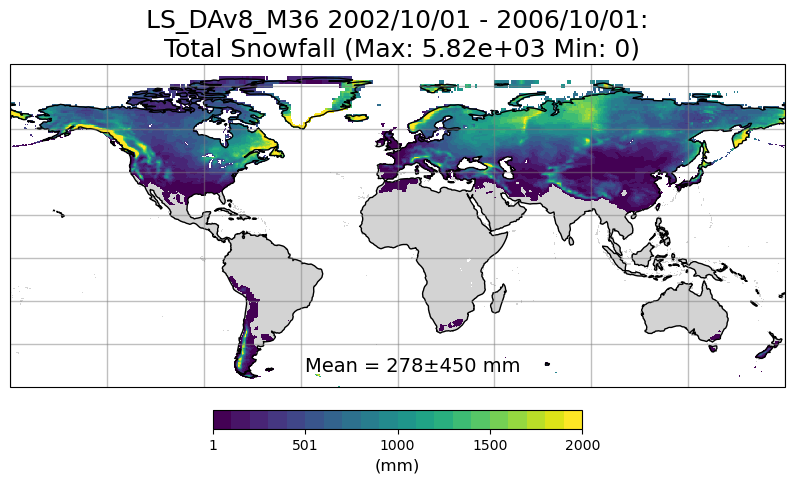

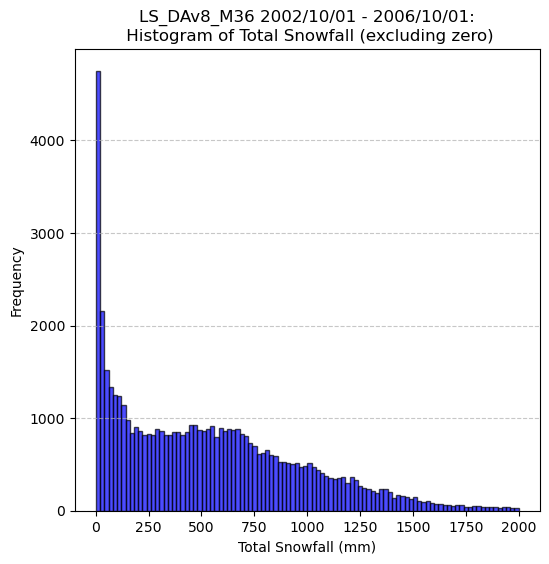

In [77]:
# Extract and plot total snowfall over the experiement period
var = variables["snowfall_land"]

# Extract the variable
var_data = ds[var].values

# Convert the units from kg/m2/sec to mm/month using seconds_in_month
var_data = var_data * seconds_in_month

# Calculate the total snowfall over the experiment period
total_snowfall = np.sum(var_data, axis=0)

# Plot the total snowfall
map_array[:, 0] = total_snowfall

maxval = np.nanmax(map_array[:, 0]) 
minval = np.nanmin(map_array[:, 0]) 
plot_global_tight_pcm(map_array,False, True,f'{expt_name} {start_date_str} - {end_date_str}:\n Total Snowfall (Max: {maxval:.3g} Min: {minval:.3g})','mm', 1, 2000)

# Flatten the array and remove NaN values for the histogram
total_snowfall_flat = total_snowfall.flatten()
total_snowfall_flat = total_snowfall_flat[~np.isnan(total_snowfall_flat)]
total_snowfall_flat = total_snowfall_flat[(total_snowfall_flat >= 1) & (total_snowfall_flat <= 2000)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(total_snowfall_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of Total Snowfall (excluding zero)')
plt.xlabel('Total Snowfall (mm)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


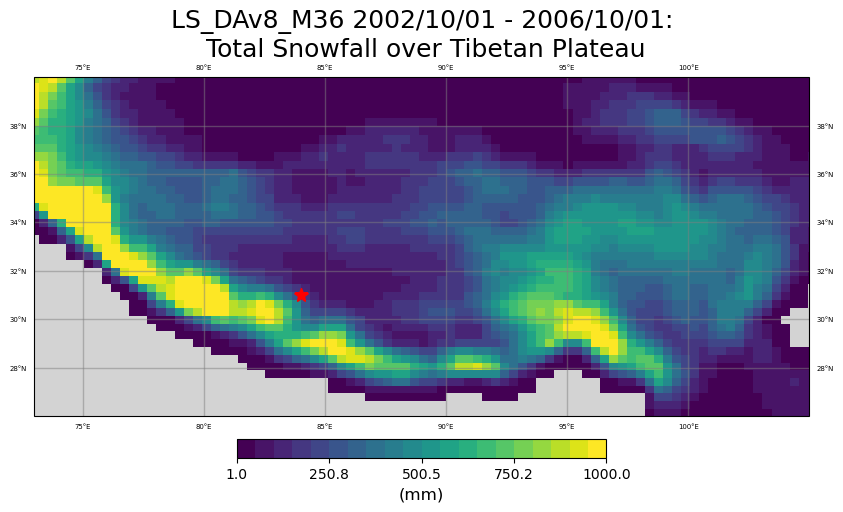

In [78]:
plot_tb_tight_pcm(map_array,False, False,f'{expt_name} {start_date_str} - {end_date_str}:\n Total Snowfall over Tibetan Plateau','mm', 1, 1000)

In [79]:
lon_value = -76.87 # -105.25 # 84.0
lat_value = 39.0 # 40.01 # 31.0

# find the index of the tile closest to the given lat/lon
tile_index = np.argmin((lat.values - lat_value)**2 + (lon.values - lon_value)**2)
print(tile_index)

17384


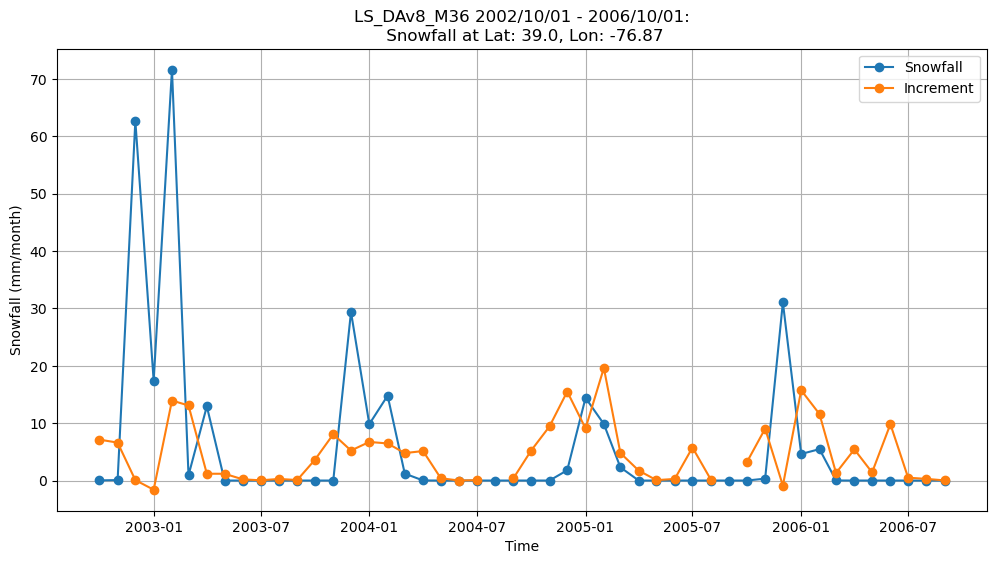

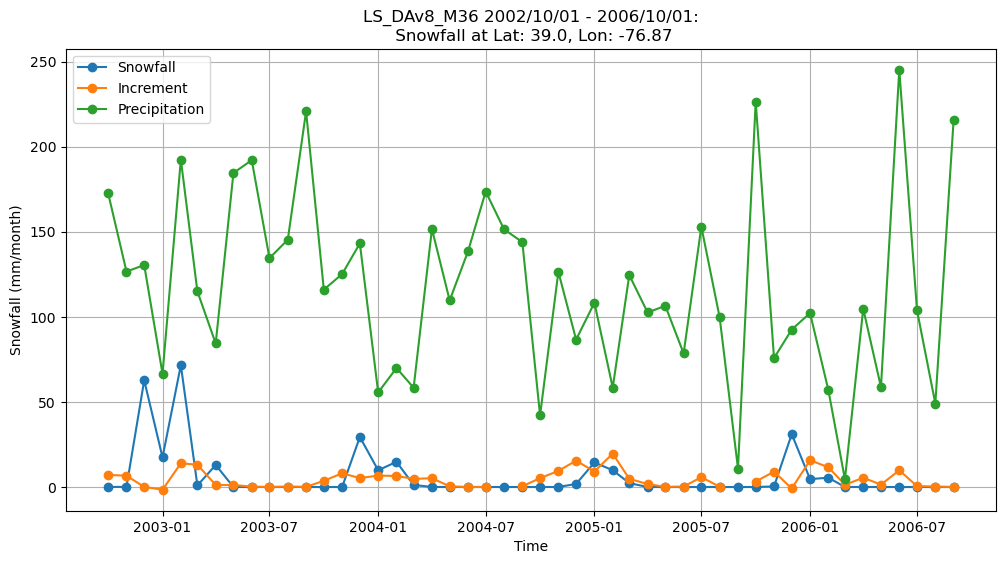

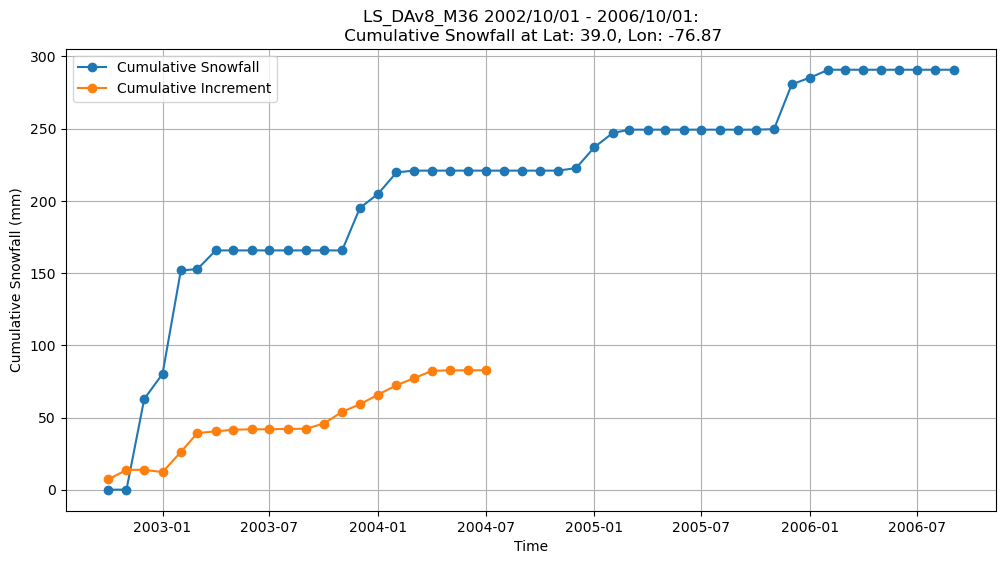

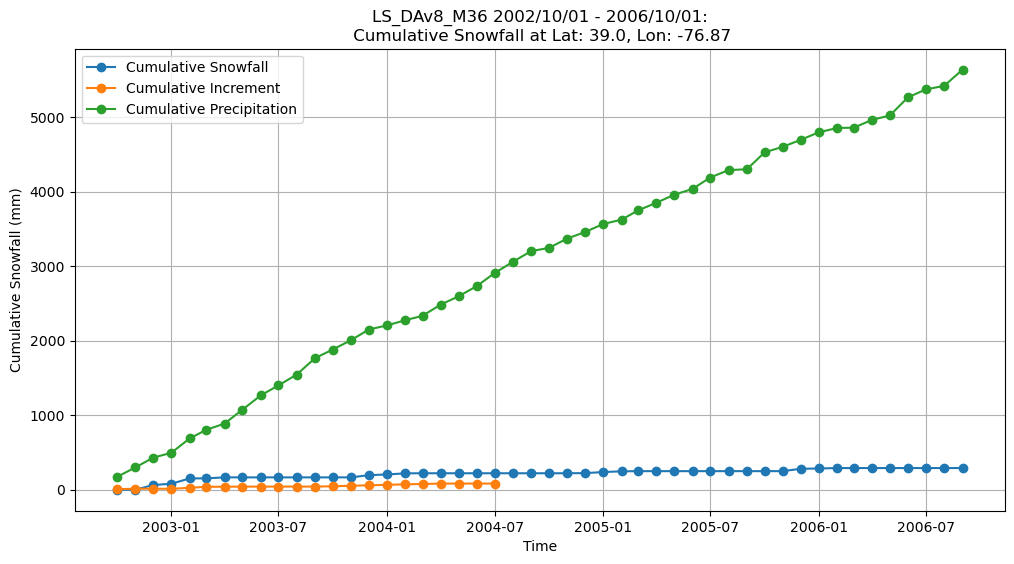

In [80]:
# Monthly time series plot of snowfall at this tile_index location
var_tile = var_data[:, tile_index]
incr_tile = total_increment[:, tile_index]
precip = ds[variables['precipitation_total_surface_flux']].values * seconds_in_month
precip = precip[:, tile_index]

# Plot the time series

plt.figure(figsize=(12, 6))
plt.plot(time_array, var_tile, marker='o')
plt.plot(time_array, incr_tile, marker='o')
plt.legend(['Snowfall', 'Increment'])
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Snowfall (mm/month)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_array, var_tile, marker='o')
plt.plot(time_array, incr_tile, marker='o')
plt.plot(time_array, precip, marker='o')
plt.legend(['Snowfall', 'Increment', 'Precipitation'])
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Snowfall (mm/month)')
plt.grid()
plt.show()

# Calculate cumulative values
cumulative_snowfall = np.cumsum(var_tile)
cumulative_increment = np.cumsum(incr_tile)
cumulative_precip = np.cumsum(precip)

# Plot the cumulative time series
plt.figure(figsize=(12, 6))
plt.plot(time_array, cumulative_snowfall, marker='o')
plt.plot(time_array, cumulative_increment, marker='o')
plt.legend(['Cumulative Snowfall', 'Cumulative Increment'])
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Cumulative Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Cumulative Snowfall (mm)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_array, cumulative_snowfall, marker='o')
plt.plot(time_array, cumulative_increment, marker='o')
plt.plot(time_array, cumulative_precip, marker='o')
plt.legend(['Cumulative Snowfall', 'Cumulative Increment', 'Cumulative Precipitation'])
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Cumulative Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Cumulative Snowfall (mm)')
plt.grid()
plt.show()

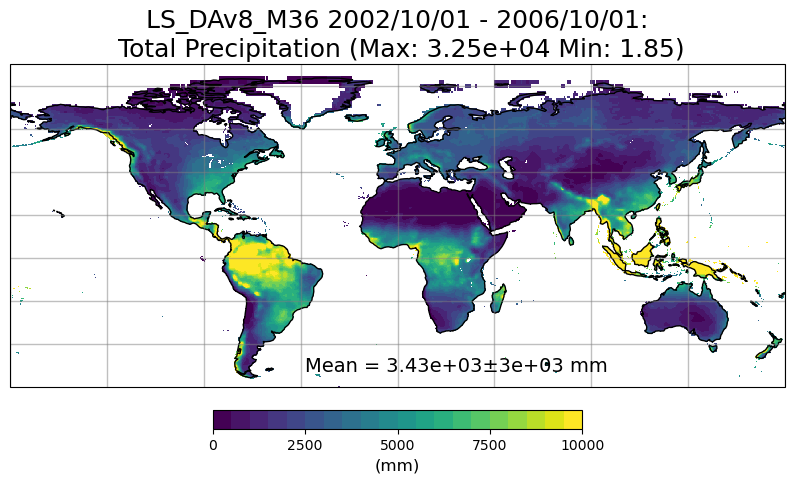

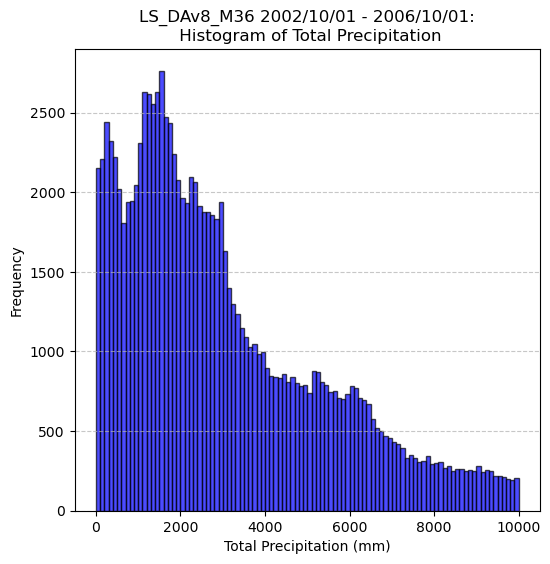

In [44]:
# Calcaulte cumulative precipitation, variable is 'precipitation_total_surface_flux'
var = variables["precipitation_total_surface_flux"]

# Extract the variable
var_data = ds[var].values

# Convert the units from kg/m2/sec to mm/month using seconds_in_month
var_data = var_data * seconds_in_month

# Calculate the total snowfall over the experiment period
total_precip = np.sum(var_data, axis=0)

# Plot the total snowfall
map_array[:, 0] = total_precip

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array,False, True,f'{expt_name} {start_date_str} - {end_date_str}:\n Total Precipitation (Max: {maxval:.3g} Min: {minval:.3g})','mm', 0, 10000)

# Flatten the array and remove NaN values for the histogram
total_precip_flat = total_precip.flatten()
total_precip_flat = total_precip_flat[~np.isnan(total_precip_flat)]
total_precip_flat = total_precip_flat[(total_precip_flat >= 0) & (total_precip_flat <= 10000)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(total_precip_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of Total Precipitation')
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


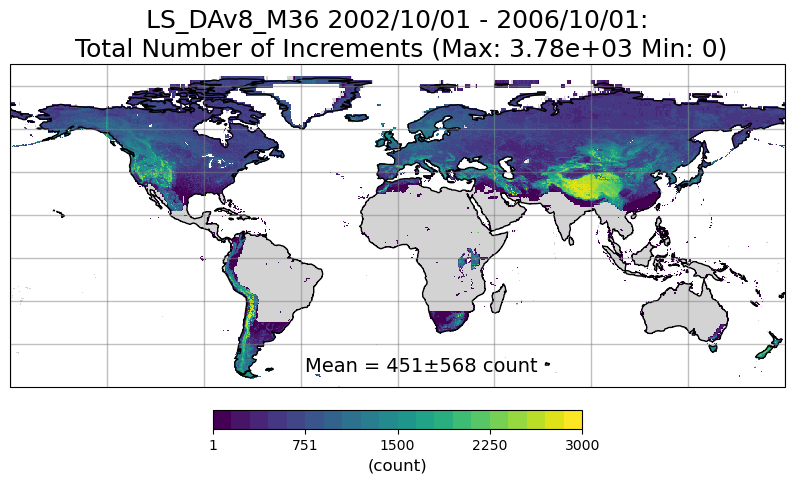

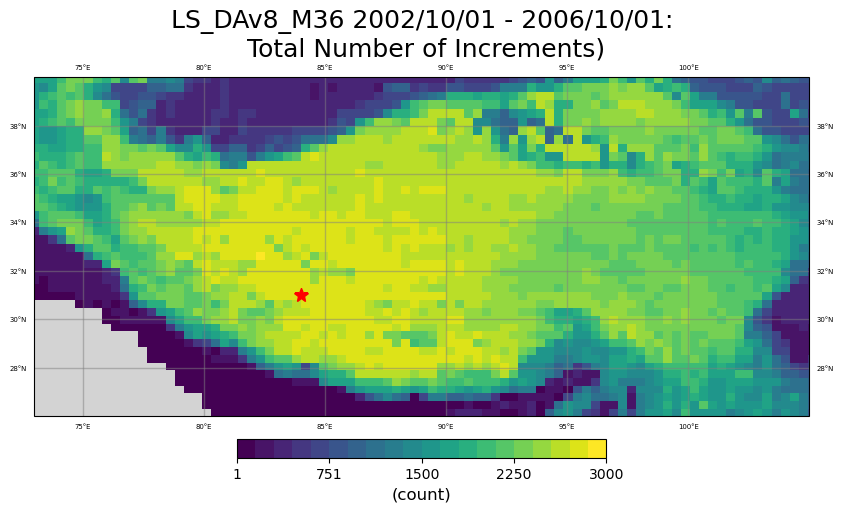

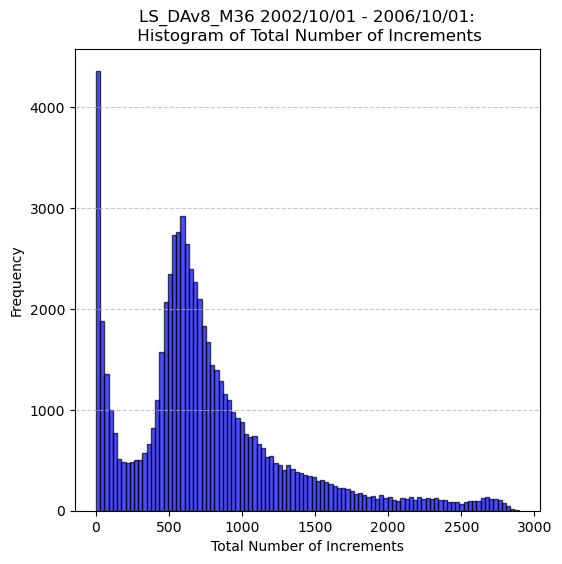

In [45]:
# Map for total number of increments
map_array[:, 0] = np.nansum(snow_incr_count, axis=0)

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, True, f'{expt_name} {start_date_str} - {end_date_str}:\n Total Number of Increments (Max: {maxval:.3g} Min: {minval:.3g})', 'count', 1, 3000)

plot_tb_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Total Number of Increments)', 'count', 1, 3000)


# Flatten the array and remove NaN values for the histogram
total_incr_count_flat = map_array[:, 0].flatten()
total_incr_count_flat = total_incr_count_flat[~np.isnan(total_incr_count_flat)]
total_incr_count_flat = total_incr_count_flat[(total_incr_count_flat >= 1) & (total_incr_count_flat <= 3000)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(total_incr_count_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of Total Number of Increments')
plt.xlabel('Total Number of Increments')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


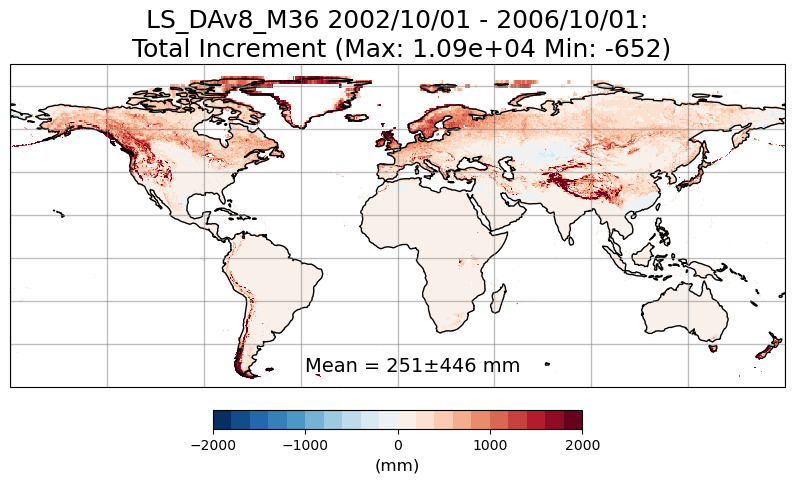

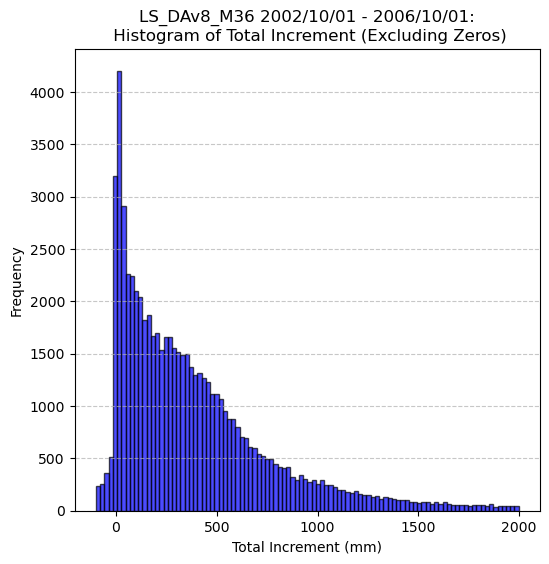

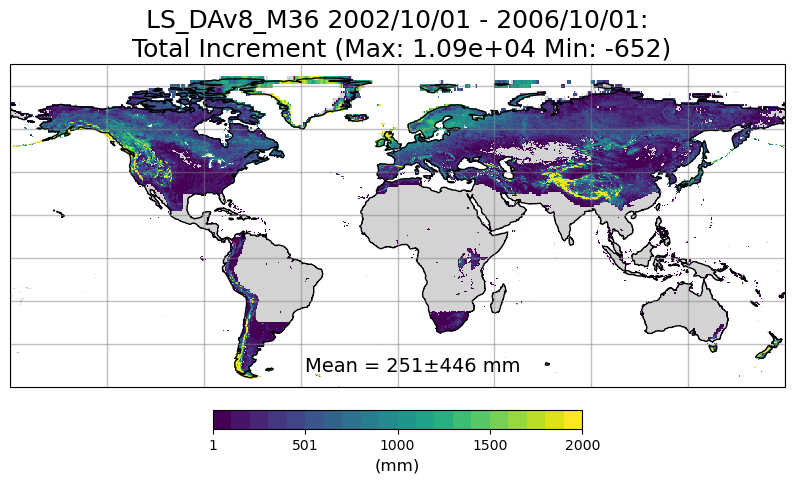

In [46]:

# Map for total increment
total_increments = np.nansum(total_increment, axis=0)

map_array[:, 0] = np.nansum(total_increment, axis=0)

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, True, f'{expt_name} {start_date_str} - {end_date_str}:\n Total Increment (Max: {maxval:.3g} Min: {minval:.3g})', 'mm', -2000, 2000)

# Flatten the array and remove NaN values for the histogram
total_increments_flat = total_increments.flatten()
total_increments_flat = total_increments_flat[~np.isnan(total_increments_flat)]
total_increments_flat = total_increments_flat[(total_increments_flat != 0) & (total_increments_flat >= -100) & (total_increments_flat <= 2000)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(total_increments_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of Total Increment (Excluding Zeros)')
plt.xlabel('Total Increment (mm)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plot_global_tight_pcm(map_array, False, True, f'{expt_name} {start_date_str} - {end_date_str}:\n Total Increment (Max: {maxval:.3g} Min: {minval:.3g})', 'mm', 1, 2000)

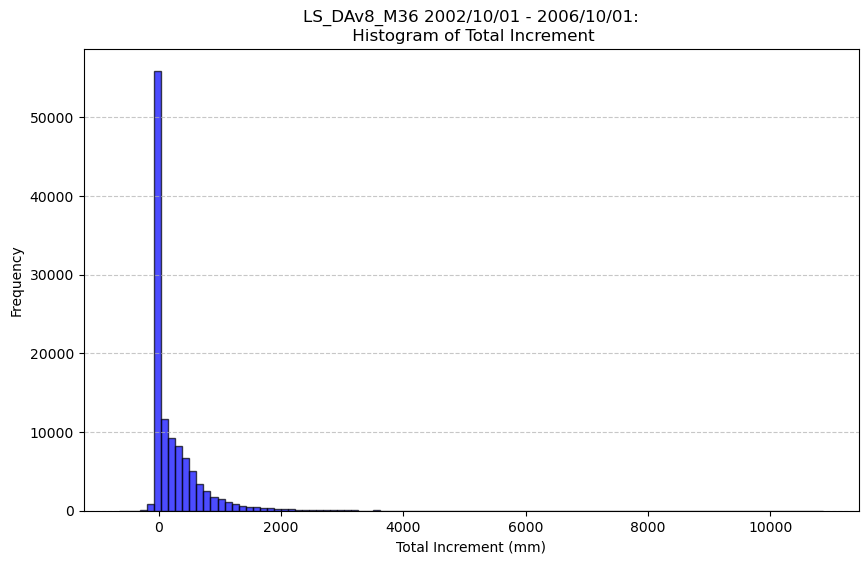

In [47]:
# Calculate the total increment summed over the time dimension
total_increment_sum = np.nansum(total_increment, axis=0)

# Flatten the array and remove NaN values for the histogram
total_increment_flat = total_increment_sum.flatten()
total_increment_flat = total_increment_flat[~np.isnan(total_increment_flat)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(total_increment_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of Total Increment')
plt.xlabel('Total Increment (mm)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_36545/3788179743.py:2: RuntimeWarning: divide by zero encountered in divide
  fraction = total_increments / total_snowfall
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_36545/3788179743.py:2: RuntimeWarning: invalid value encountered in divide
  fraction = total_increments / total_snowfall


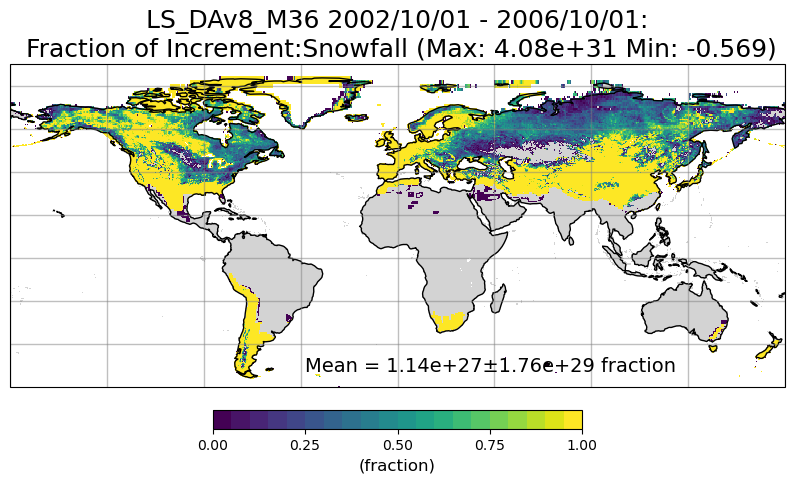

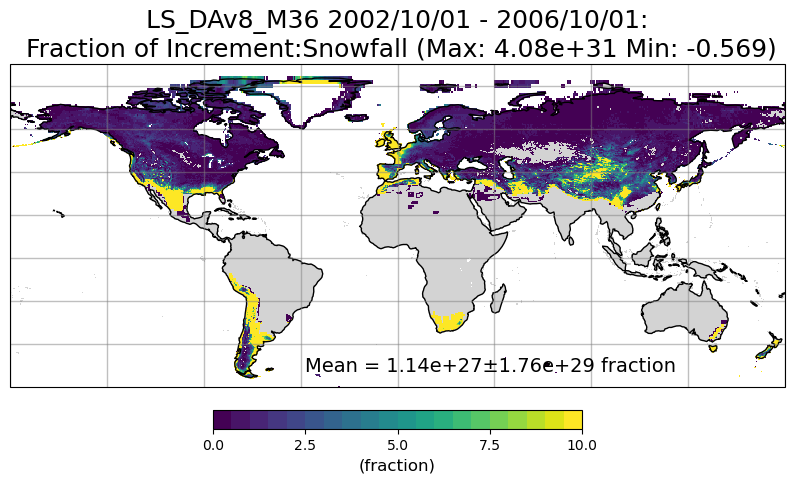

In [48]:
# Calculate the fraction of total increments to total snowfall
fraction = total_increments / total_snowfall
fraction = np.where(np.isfinite(fraction), fraction, np.nan)  # Handle division by zero or NaN

# Update the map array with the fraction values
map_array[:, 0] = fraction

# Plot the fraction
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, True, f'{expt_name} {start_date_str} - {end_date_str}:\n Fraction of Increment:Snowfall (Max: {maxval:.3g} Min: {minval:.3g})', 'fraction', 0, 1)

plot_global_tight_pcm(map_array, False, True, f'{expt_name} {start_date_str} - {end_date_str}:\n Fraction of Increment:Snowfall (Max: {maxval:.3g} Min: {minval:.3g})', 'fraction', 0, 10)


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_36545/475754624.py:2: RuntimeWarning: divide by zero encountered in divide
  percent_change = (total_snowfall + total_increments) / total_snowfall
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_36545/475754624.py:2: RuntimeWarning: invalid value encountered in divide
  percent_change = (total_snowfall + total_increments) / total_snowfall


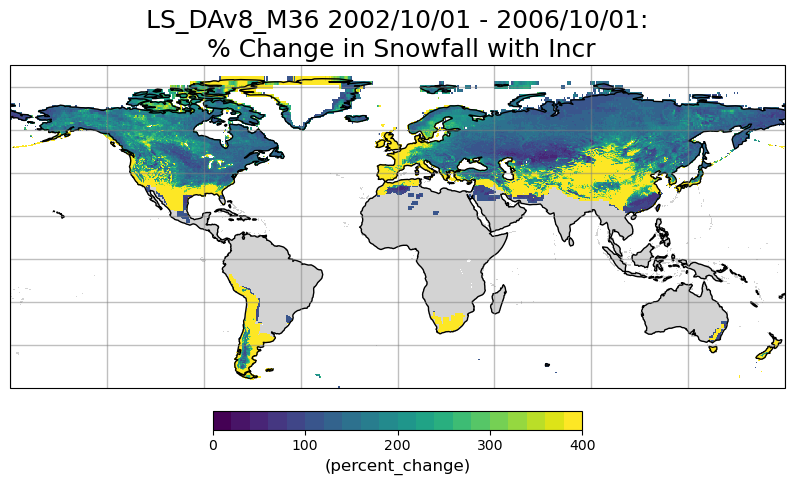

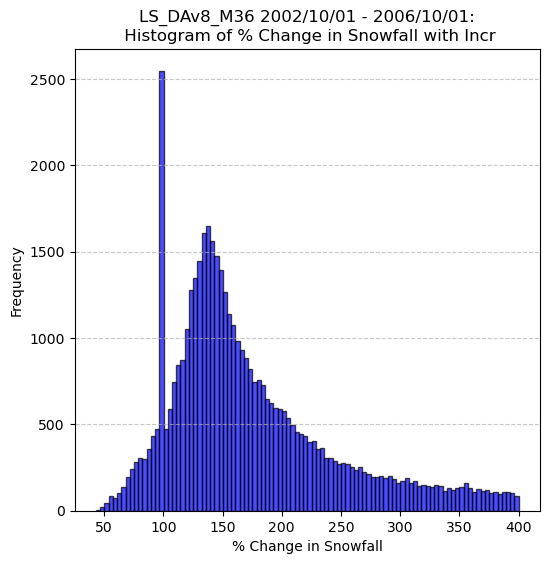

In [49]:

# Calculate % change in snowfall when you add increment
percent_change = (total_snowfall + total_increments) / total_snowfall
percent_change = np.where(np.isfinite(percent_change), percent_change, np.nan)  # Handle division by zero or NaN
percent_change = percent_change * 100

# Update the map array with the percent change values
map_array[:, 0] = percent_change

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Snowfall with Incr', 'percent_change', 0, 400)

# Flatten the array and remove NaN values for the histogram
percent_change_flat = percent_change.flatten()
percent_change_flat = percent_change_flat[~np.isnan(percent_change_flat)]
percent_change_flat = percent_change_flat[(percent_change_flat >= 0) & (percent_change_flat <= 400)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(percent_change_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of % Change in Snowfall with Incr')
plt.xlabel('% Change in Snowfall')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

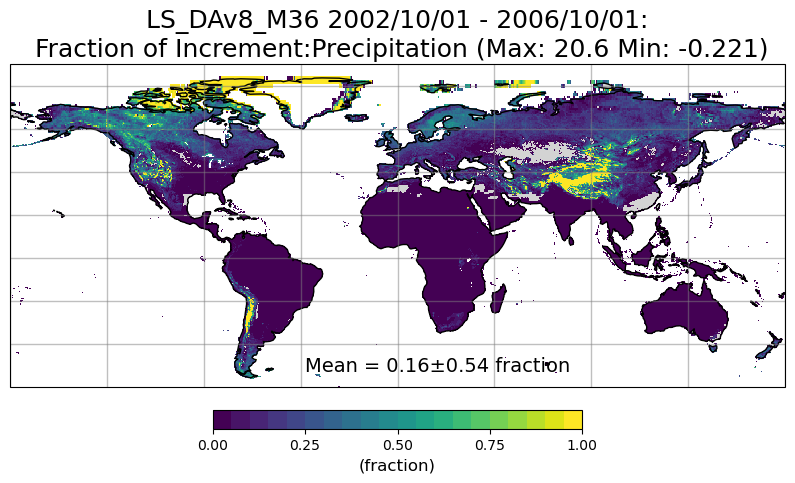

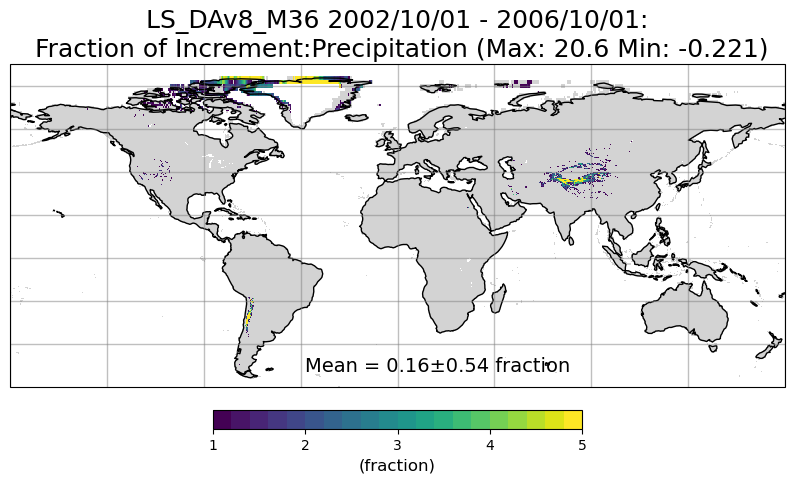

In [50]:
# Calculate the fraction of total increments to total precipitation
fraction_precip = total_increments / total_precip
fraction_precip = np.where(np.isfinite(fraction_precip), fraction_precip, np.nan)  # Handle division by zero or NaN

# Update the map array with the fraction values
map_array[:, 0] = fraction_precip

# Plot the fraction
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, True, f'{expt_name} {start_date_str} - {end_date_str}:\n Fraction of Increment:Precipitation (Max: {maxval:.3g} Min: {minval:.3g})', 'fraction', 0, 1)

plot_global_tight_pcm(map_array, False, True, f'{expt_name} {start_date_str} - {end_date_str}:\n Fraction of Increment:Precipitation (Max: {maxval:.3g} Min: {minval:.3g})', 'fraction', 1, 5)

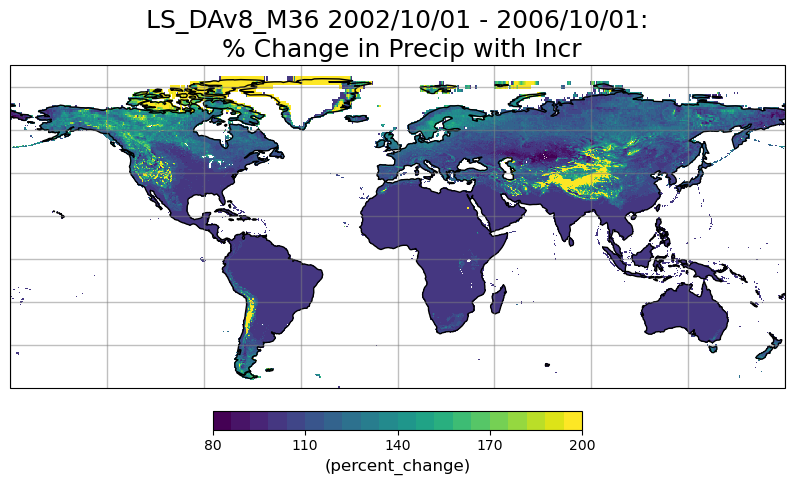

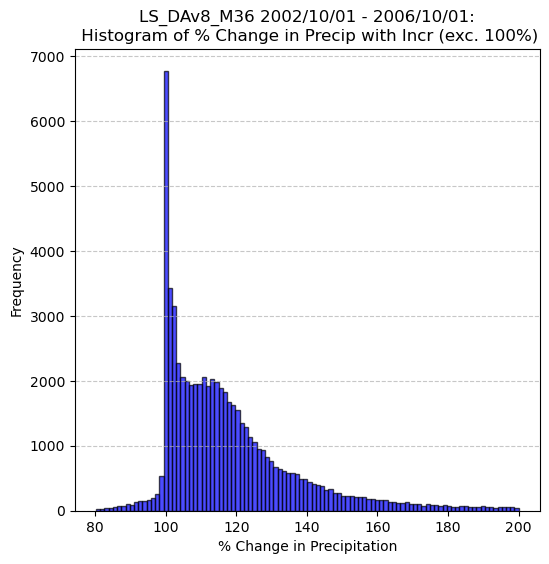

In [51]:
# Calculate and plot percent change in precipitation when you add increment
percent_change_precip = (total_precip + total_increments) / total_precip
percent_change_precip = np.where(np.isfinite(percent_change_precip), percent_change_precip, np.nan)  # Handle division by zero or NaN
percent_change_precip = percent_change_precip * 100

# Update the map array with the percent change values
map_array[:, 0] = percent_change_precip

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Precip with Incr', 'percent_change', 80, 200)

# Flatten the array and remove NaN values for the histogram
percent_change_precip_flat = percent_change_precip.flatten()
percent_change_precip_flat = percent_change_precip_flat[~np.isnan(percent_change_precip_flat)]
percent_change_precip_flat = percent_change_precip_flat[(percent_change_precip_flat > 80) & (percent_change_precip_flat != 100) & (percent_change_precip_flat <= 200)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(percent_change_precip_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of % Change in Precip with Incr (exc. 100%)')
plt.xlabel('% Change in Precipitation')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [52]:
expt_name = 'LS_OLv8_M36'

# Define the path directory
root_directory = f'/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/{expt_name}/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'

# List all tavg24 files in the root directory
files = glob.glob(os.path.join(root_directory, '*tavg24_1d_lnd_Nt*.nc'))

# Filter files based on the date range
filtered_files = []
for file in files:
    # Extract the date part from the filename
    filename = os.path.basename(file)
    date_str = filename.split('.')[-2]  # Extract the date part (e.g., 200401)
    file_date = datetime.strptime(date_str, '%Y%m')

    # Check if the file date is within the range
    if start_date <= file_date < end_date:
        filtered_files.append(file)

# Load the data 
ds_ol = xr.open_mfdataset(filtered_files, combine='nested', concat_dim="time")

# Sort the dataset by the time dimension
ds_ol = ds_ol.sortby('time')

In [53]:
ol_evap = ds_ol[variables['total_evaporation_land']].values * seconds_in_month
da_evap = ds[variables['total_evaporation_land']].values * seconds_in_month

ol_runoff = ds_ol[variables['overland_runoff_including_throughflow']].values * seconds_in_month
da_runoff = ds[variables['overland_runoff_including_throughflow']].values * seconds_in_month

ol_snowmelt = ds_ol[variables['snowmelt_flux_land']].values * seconds_in_month
da_snowmelt = ds[variables['snowmelt_flux_land']].values * seconds_in_month

ol_baseflow = ds_ol[variables['baseflow_flux_land']].values * seconds_in_month
da_baseflow = ds[variables['baseflow_flux_land']].values * seconds_in_month

ol_soil_moisture = ds_ol[variables['sm_surface']].values
da_soil_moisture = ds[variables['sm_surface']].values

ol_rzmc = ds_ol[variables['sm_rootzone']].values
da_rzmc = ds[variables['sm_rootzone']].values

ol_sm_profile = ds_ol[variables['sm_profile']].values
da_sm_profile = ds[variables['sm_profile']].values

ol_evap_sum = np.nansum(ol_evap, axis=0)
da_evap_sum = np.nansum(da_evap, axis=0)

ol_runoff_sum = np.nansum(ol_runoff, axis=0)
da_runoff_sum = np.nansum(da_runoff, axis=0)

ol_snowmelt_sum = np.nansum(ol_snowmelt, axis=0)
da_snowmelt_sum = np.nansum(da_snowmelt, axis=0)

ol_baseflow_sum = np.nansum(ol_baseflow, axis=0)
da_baseflow_sum = np.nansum(da_baseflow, axis=0)

ol_soil_moisture_mean = np.nanmean(ol_soil_moisture, axis=0)
da_soil_moisture_mean = np.nanmean(da_soil_moisture, axis=0)

ol_rzmc_mean = np.nanmean(ol_rzmc, axis=0)
da_rzmc_mean = np.nanmean(da_rzmc, axis=0)

ol_sm_profile_mean = np.nanmean(ol_sm_profile, axis=0)
da_sm_profile_mean = np.nanmean(da_sm_profile, axis=0)


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_36545/2157152030.py:2: RuntimeWarning: divide by zero encountered in divide
  percent_change_snowmelt = da_snowmelt_sum / ol_snowmelt_sum
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_36545/2157152030.py:2: RuntimeWarning: invalid value encountered in divide
  percent_change_snowmelt = da_snowmelt_sum / ol_snowmelt_sum


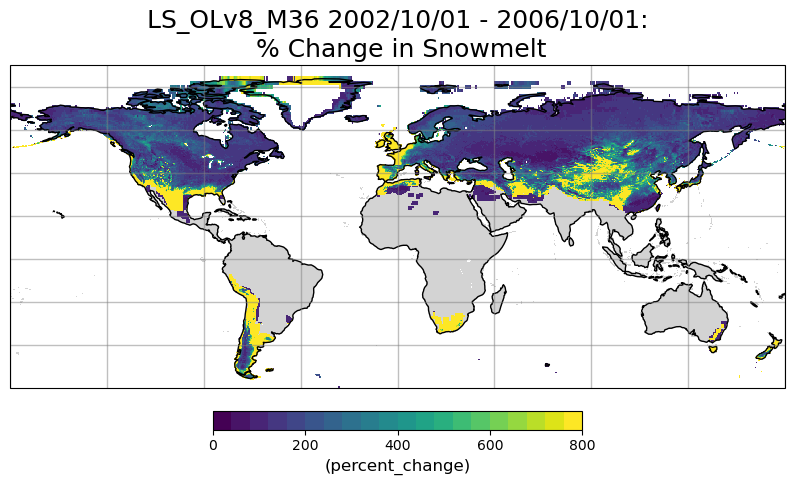

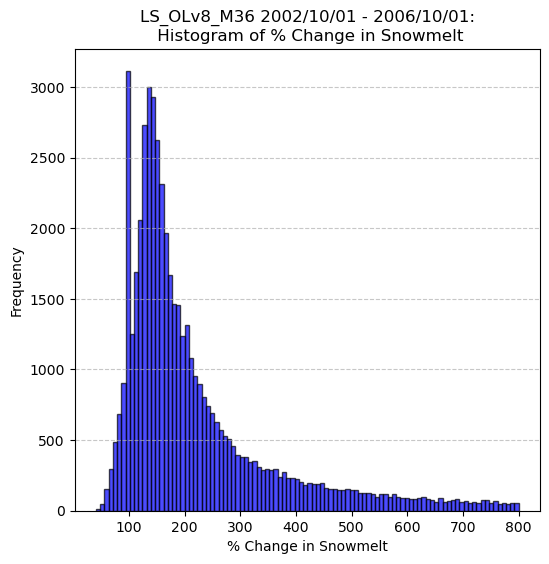

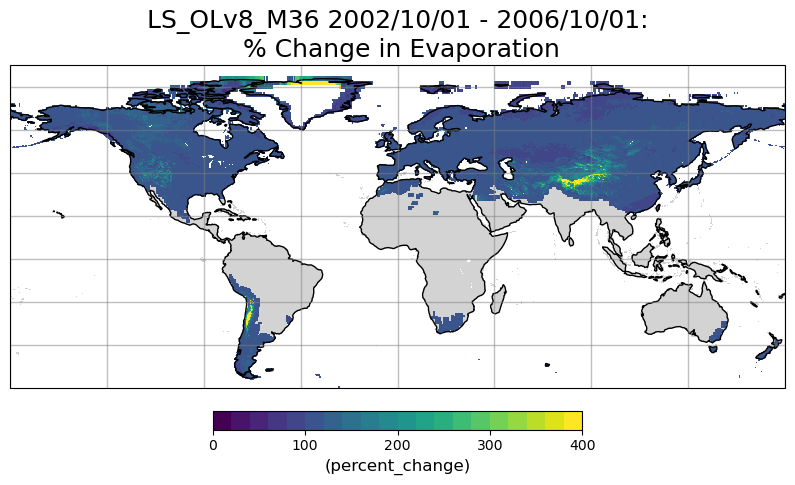

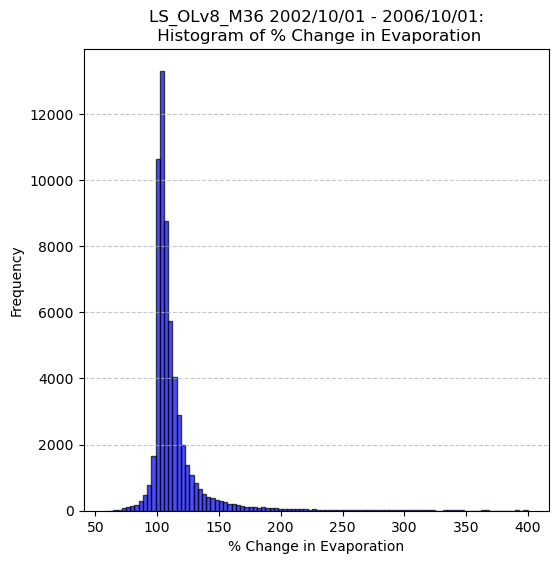

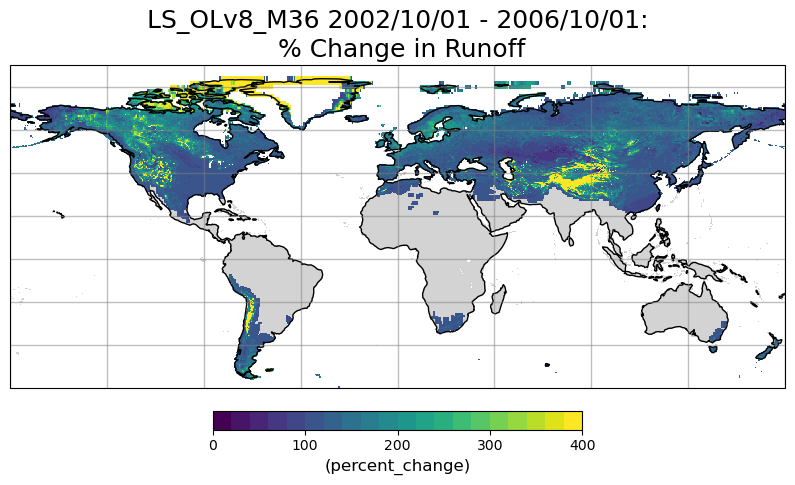

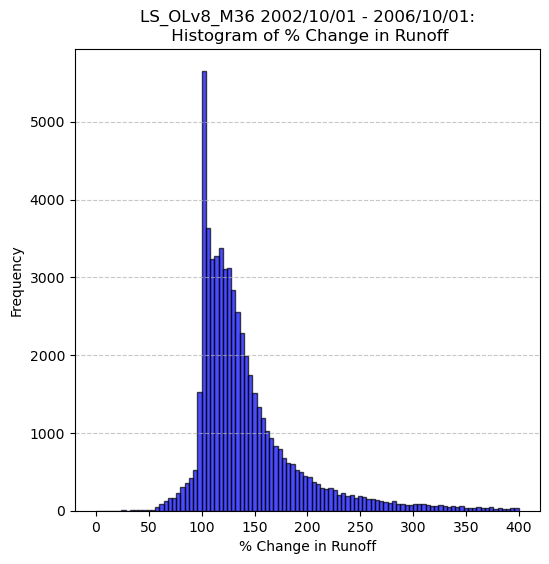

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_36545/2157152030.py:95: RuntimeWarning: divide by zero encountered in divide
  percent_change_baseflow = da_baseflow_sum / ol_baseflow_sum
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_36545/2157152030.py:95: RuntimeWarning: invalid value encountered in divide
  percent_change_baseflow = da_baseflow_sum / ol_baseflow_sum


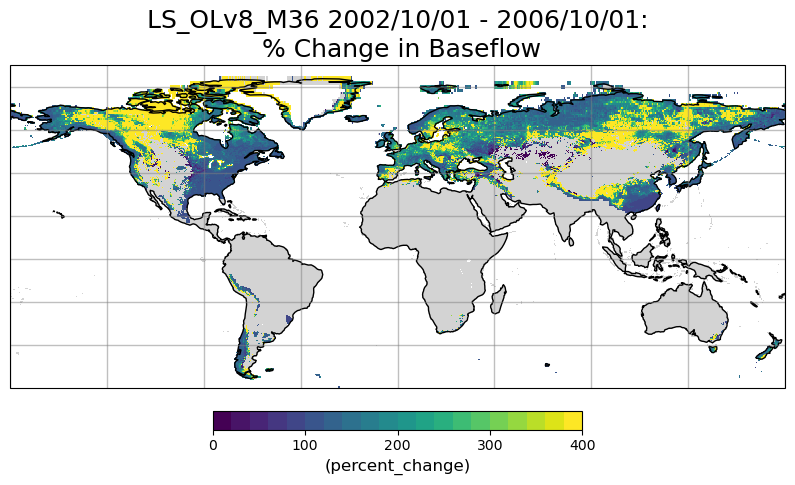

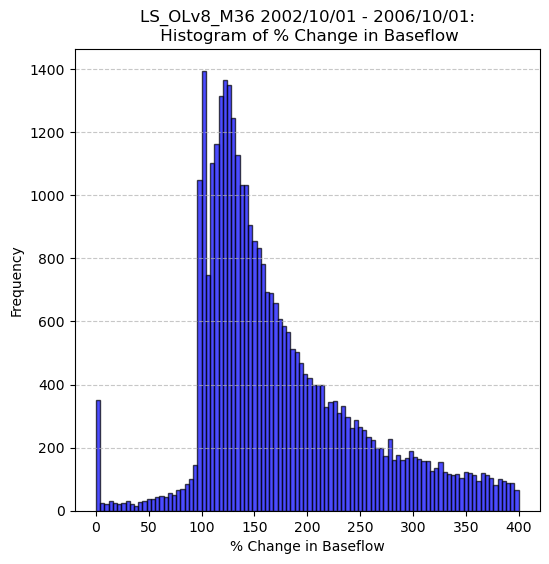

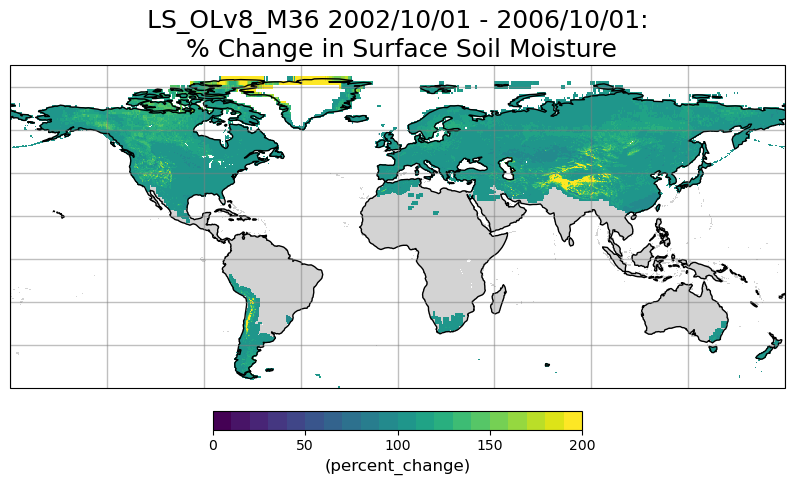

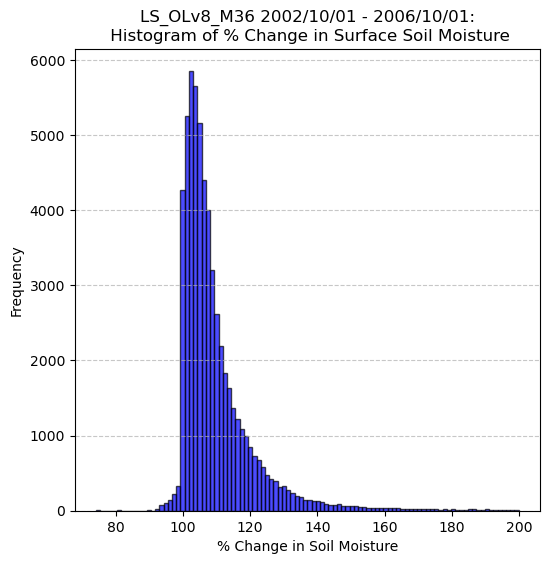

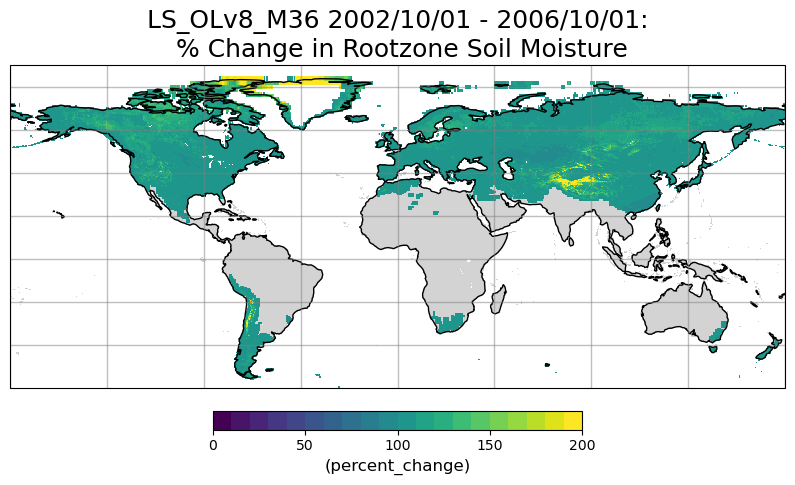

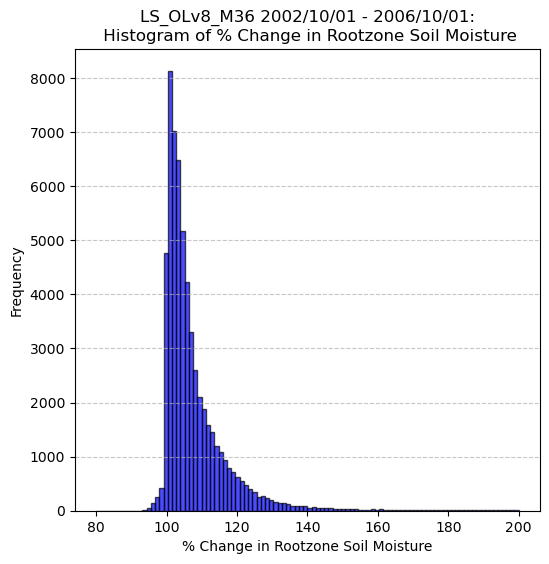

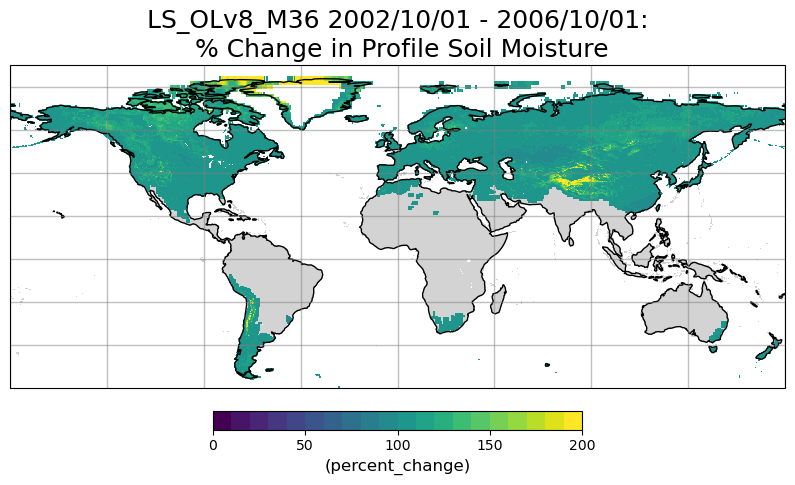

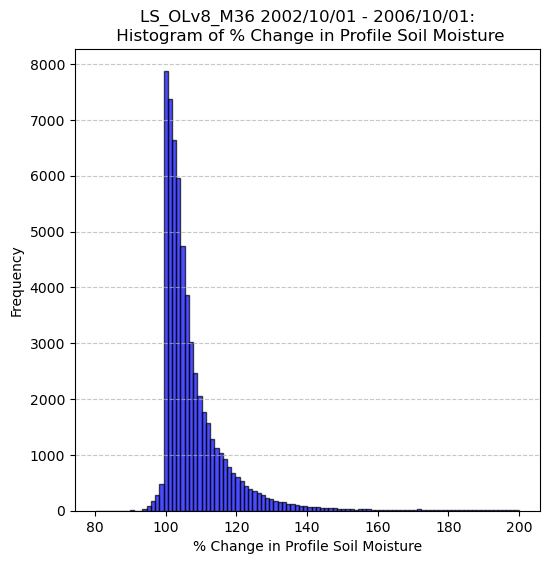

In [54]:

# Map percent change in snowmelt
percent_change_snowmelt = da_snowmelt_sum / ol_snowmelt_sum
percent_change_snowmelt = np.where(np.isfinite(percent_change_snowmelt), percent_change_snowmelt, np.nan)  # Handle division by zero or NaN
percent_change_snowmelt = percent_change_snowmelt * 100

# Create a mask where percent_change_snowmelt is NaN
nan_mask = np.isnan(percent_change_snowmelt)

# Update the map array with the percent change values
map_array[:, 0] = percent_change_snowmelt

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Snowmelt', 'percent_change', 0, 800)

# Probability density function of percent change in snowmelt (resctrict range from 0 - 1000%)

# Flatten the array and remove NaN values for the histogram
percent_change_snowmelt_flat = percent_change_snowmelt.flatten()
percent_change_snowmelt_flat = percent_change_snowmelt_flat[~np.isnan(percent_change_snowmelt_flat)]
percent_change_snowmelt_flat = percent_change_snowmelt_flat[(percent_change_snowmelt_flat >= 0) & (percent_change_snowmelt_flat <= 800)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(percent_change_snowmelt_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of % Change in Snowmelt')
plt.xlabel('% Change in Snowmelt')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Map percent change in evaporation
percent_change_evap = da_evap_sum / ol_evap_sum
percent_change_evap = np.where(np.isfinite(percent_change_evap), percent_change_evap, np.nan)  # Handle division by zero or NaN
percent_change_evap = percent_change_evap * 100
# Apply the NaN mask to percent_change_evap
percent_change_evap[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_evap

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Evaporation', 'percent_change', 0, 400)

# Probability density function of percent change in evaporation (resctrict range from 0 - 1000%)

# Flatten the array and remove NaN values for the histogram
percent_change_evap_flat = percent_change_evap.flatten()
percent_change_evap_flat = percent_change_evap_flat[~np.isnan(percent_change_evap_flat)]
percent_change_evap_flat = percent_change_evap_flat[(percent_change_evap_flat >= 0) & (percent_change_evap_flat <= 400)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(percent_change_evap_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of % Change in Evaporation')
plt.xlabel('% Change in Evaporation')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Map percent change in runoff
percent_change_runoff = da_runoff_sum / ol_runoff_sum
percent_change_runoff = np.where(np.isfinite(percent_change_runoff), percent_change_runoff, np.nan)  # Handle division by zero or NaN
percent_change_runoff = percent_change_runoff * 100
percent_change_runoff[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_runoff

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Runoff', 'percent_change', 0, 400)

# Probability density function of percent change in runoff (resctrict range from 0 - 1000%)

# Flatten the array and remove NaN values for the histogram
percent_change_runoff_flat = percent_change_runoff.flatten()
percent_change_runoff_flat = percent_change_runoff_flat[~np.isnan(percent_change_runoff_flat)]
percent_change_runoff_flat = percent_change_runoff_flat[(percent_change_runoff_flat >= 0) & (percent_change_runoff_flat <= 400)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(percent_change_runoff_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of % Change in Runoff')
plt.xlabel('% Change in Runoff')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Map percent change in baseflow
percent_change_baseflow = da_baseflow_sum / ol_baseflow_sum
percent_change_baseflow = np.where(np.isfinite(percent_change_baseflow), percent_change_baseflow, np.nan)  # Handle division by zero or NaN
percent_change_baseflow = percent_change_baseflow * 100
percent_change_baseflow[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_baseflow

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Baseflow', 'percent_change', 0, 400)

# Probability density function of percent change in baseflow (resctrict range from 0 - 1000%)

# Flatten the array and remove NaN values for the histogram
percent_change_baseflow_flat = percent_change_baseflow.flatten()
percent_change_baseflow_flat = percent_change_baseflow_flat[~np.isnan(percent_change_baseflow_flat)]
percent_change_baseflow_flat = percent_change_baseflow_flat[(percent_change_baseflow_flat >= 0) & (percent_change_baseflow_flat <= 400)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(percent_change_baseflow_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of % Change in Baseflow')
plt.xlabel('% Change in Baseflow')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Map percent change in soil moisture
percent_change_soil_moisture = da_soil_moisture_mean / ol_soil_moisture_mean
percent_change_soil_moisture = np.where(np.isfinite(percent_change_soil_moisture), percent_change_soil_moisture, np.nan)  # Handle division by zero or NaN
percent_change_soil_moisture = percent_change_soil_moisture * 100
percent_change_soil_moisture[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_soil_moisture

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Surface Soil Moisture', 'percent_change', 0, 200)

# Probability density function of percent change in soil moisture (resctrict range from 0 - 1000%)

# Flatten the array and remove NaN values for the histogram
percent_change_soil_moisture_flat = percent_change_soil_moisture.flatten()
percent_change_soil_moisture_flat = percent_change_soil_moisture_flat[~np.isnan(percent_change_soil_moisture_flat)]
percent_change_soil_moisture_flat = percent_change_soil_moisture_flat[(percent_change_soil_moisture_flat >= 0) & (percent_change_soil_moisture_flat <= 200)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(percent_change_soil_moisture_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of % Change in Surface Soil Moisture')
plt.xlabel('% Change in Soil Moisture')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Map percent change in rootzone soil moisture
percent_change_rzmc = da_rzmc_mean / ol_rzmc_mean
percent_change_rzmc = np.where(np.isfinite(percent_change_rzmc), percent_change_rzmc, np.nan)  # Handle division by zero or NaN
percent_change_rzmc = percent_change_rzmc * 100
percent_change_rzmc[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_rzmc

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Rootzone Soil Moisture', 'percent_change', 0, 200)

# Probability density function of percent change in rootzone soil moisture (resctrict range from 0 - 1000%)

# Flatten the array and remove NaN values for the histogram
percent_change_rzmc_flat = percent_change_rzmc.flatten()
percent_change_rzmc_flat = percent_change_rzmc_flat[~np.isnan(percent_change_rzmc_flat)]
percent_change_rzmc_flat = percent_change_rzmc_flat[(percent_change_rzmc_flat >= 0) & (percent_change_rzmc_flat <= 200)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(percent_change_rzmc_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of % Change in Rootzone Soil Moisture')
plt.xlabel('% Change in Rootzone Soil Moisture')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Map percent change in profile soil moisture
percent_change_sm_profile = da_sm_profile_mean / ol_sm_profile_mean
percent_change_sm_profile = np.where(np.isfinite(percent_change_sm_profile), percent_change_sm_profile, np.nan)  # Handle division by zero or NaN
percent_change_sm_profile = percent_change_sm_profile * 100
percent_change_sm_profile[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_sm_profile

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Profile Soil Moisture', 'percent_change', 0, 200)

# Probability density function of percent change in profile soil moisture (resctrict range from 0 - 1000%)

# Flatten the array and remove NaN values for the histogram
percent_change_sm_profile_flat = percent_change_sm_profile.flatten()
percent_change_sm_profile_flat = percent_change_sm_profile_flat[~np.isnan(percent_change_sm_profile_flat)]
percent_change_sm_profile_flat = percent_change_sm_profile_flat[(percent_change_sm_profile_flat >= 0) & (percent_change_sm_profile_flat <= 200)]

# Plot the histogram
plt.figure(figsize=(6, 6))
plt.hist(percent_change_sm_profile_flat, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Histogram of % Change in Profile Soil Moisture')
plt.xlabel('% Change in Profile Soil Moisture')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
